In [53]:
from sklearn import datasets
from sklearn import preprocessing
from __future__ import print_function
from sklearn import ensemble
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import pandas as pd
import numpy as np
import boto3
import argparse
import os
import json
import sagemaker
import matplotlib.pyplot as plt
import itertools

Data preprocessing.

In [31]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns = iris['feature_names']+['target'])
df.rename(columns = {'sepal length (cm)':'sepal_length', 'sepal width (cm)':'sepal_width','petal length (cm)':'petal_length','petal width (cm)':'petal_width'}, inplace = True)
df.target = df.target.astype(int)
df = df.iloc[:, [4,0,1,2,3]]

train, validate, test = np.split(df.sample(frac=1, random_state=42),[int(.6*len(df)), int(.8*len(df))])
train.to_csv('train.csv',index=False,header=False)
validate.to_csv('validate.csv',index=False,header=False)
test.to_csv('test.csv',index=False,header=False)

In [30]:
print(df)

     target  sepal_length  sepal_width  petal_length  petal_width
0         0           5.1          3.5           1.4          0.2
1         0           4.9          3.0           1.4          0.2
2         0           4.7          3.2           1.3          0.2
3         0           4.6          3.1           1.5          0.2
4         0           5.0          3.6           1.4          0.2
..      ...           ...          ...           ...          ...
145       2           6.7          3.0           5.2          2.3
146       2           6.3          2.5           5.0          1.9
147       2           6.5          3.0           5.2          2.0
148       2           6.2          3.4           5.4          2.3
149       2           5.9          3.0           5.1          1.8

[150 rows x 5 columns]


Upload to S3.

In [32]:
def uploadFileToS3(localFileLocation, remoteFileLocation):
    client = boto3.client('s3')
    s3 = boto3.resource('s3')
    s3.meta.client.upload_file(localFileLocation, 'pengantar-sagemaker', remoteFileLocation)
uploadFileToS3('train.csv','train/train.csv')
uploadFileToS3('validate.csv','validate/validate.csv')
uploadFileToS3('test.csv','test/test.csv')

Training.

In [34]:
# Specify your bucket name
bucket_name = 'pengantar-sagemaker'

training_folder = r'train/train'
test_folder = r'test/test'
model_folder = r'model/'

training_data_uri = r's3://' + bucket_name + r'/' + training_folder
testing_data_uri = r's3://' + bucket_name + r'/' + test_folder
model_data_uri = r's3://' + bucket_name + r'/' + model_folder

In [36]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_session.region_name

#instance_type='ml.m5.xlarge'
instance_type='local'
estimator = SKLearn(entry_point='scikit_learn_iris.py',
                    framework_version = "0.20.0",
                    py_version = 'py3',
                    instance_type= instance_type,                     
                    role=role, 
                    output_path=model_data_uri,
                    base_job_name='sklearn-iris',
                    hyperparameters={'n_estimators': 50,'max_depth':5})

In [ ]:
estimator.fit({'training':training_data_uri,'testing':testing_data_uri})

Model Deployment

In [38]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

Attaching to o24h7sg0oe-algo-1-98568
o24h7sg0oe-algo-1-98568 | Processing /opt/ml/code
o24h7sg0oe-algo-1-98568 |   Preparing metadata (setup.py) ... done
o24h7sg0oe-algo-1-98568 | Building wheels for collected packages: scikit-learn-iris
o24h7sg0oe-algo-1-98568 |   Building wheel for scikit-learn-iris (setup.py) ... done
o24h7sg0oe-algo-1-98568 |   Created wheel for scikit-learn-iris: filename=scikit_learn_iris-1.0.0-py2.py3-none-any.whl size=6051 sha256=17b9966d61e42445aed274d3345f79507b7eca8da7a9efe62e03a8916c7c0c03
o24h7sg0oe-algo-1-98568 |   Stored in directory: /tmp/pip-ephem-wheel-cache-mmk0_uq3/wheels/3e/0f/51/2f1df833dd0412c1bc2f5ee56baac195b5be563353d111dca6
o24h7sg0oe-algo-1-98568 | Successfully built scikit-learn-iris
o24h7sg0oe-algo-1-98568 | Installing collected packages: scikit-learn-iris
o24h7sg0oe-algo-1-98568 | Successfully installed scikit-learn-iris-1.0.0
o24h7sg0oe-algo-1-98568 | WARNING: Running pip as the 'root' user can result in broken permissions and conflictin

Model Evaluation

In [45]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

o24h7sg0oe-algo-1-98568 | 172.18.0.1 - - [13/Dec/2022:04:44:30 +0000] "POST /invocations HTTP/1.1" 200 360 "-" "python-urllib3/1.26.8"


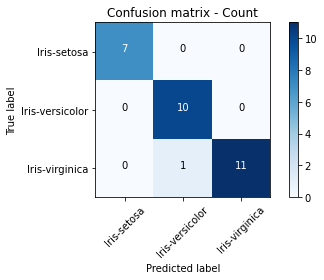

In [56]:
testDF = pd.read_csv('test.csv')
X_test = testDF.iloc[:,1:]
result = predictor.predict(X_test)
cnf_matrix = confusion_matrix(testDF.iloc[:,0],
                              result,labels=[0,1,2])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
                      title='Confusion matrix - Count')

In [58]:
print(classification_report(testDF.iloc[:,0], result, target_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.92      0.96        12

       accuracy                           0.97        29
      macro avg       0.97      0.97      0.97        29
   weighted avg       0.97      0.97      0.97        29

